In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load experiment data from directories
def load_experiments(experiment_dirs, experiment_names=None):
    """
    Loads experiments and assigns custom names for each experiment.

    Args:
        experiment_dirs (list): List of experiment directories.
        experiment_names (list or None): List of custom names for each experiment.
                                         Defaults to directory names if None.

    Returns:
        list: List of experiments with assigned names.
    """
    experiments = []
    for idx, exp_dir in enumerate(experiment_dirs):
        json_path = os.path.join(exp_dir, f"{os.path.basename(exp_dir)}.json")
        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                experiment = json.load(f)
                experiment["custom_name"] = (
                    experiment_names[idx] if experiment_names else os.path.basename(exp_dir)
                )
                experiments.append(experiment)
        else:
            print(f"Warning: JSON file not found for experiment {exp_dir}")
    return experiments

In [5]:
# Specify experiment directories
experiment_dirs = [
"Baseline_randomnonenone_2024_12_12_00_55_01",
"Baseline_quantity_skewnonenone_2025_01_07_19_59_45",
"Baseline_feature_basednonenone_2025_01_07_14_06_51"
]

# Custom names for the experiments
experiment_names = [
"Baseline",
"quantity_skew",
"feature_based"
]

output_dir = 'results/split'

# Load experiments
experiments = load_experiments(experiment_dirs, experiment_names)

In [6]:
print(len(experiments))

3


In [7]:
def extract_data(experiments, section, **kwargs):
    """
    Extracts data from the specified section of experiments.

    Args:
        experiments (list): List of experiment data.
        section (str): Section to extract data from ("config", "server_results", or "client_results").
        kwargs:
            - For "server_results":
                - round_number (int): Round number to extract data for.
                - metric_name (str): Specific metric to extract.
            - For "client_results":
                - round_number (int): Round number to extract data for.
                - client_id (int): Client ID to extract data for.
                - metric_name (str): Specific metric to extract.

    Returns:
        list: Extracted data from all experiments.
    """
    extracted_data = []

    for experiment in experiments:
        if section == "config":
            extracted_data.append(experiment.get("config", {}))

        elif section == "server_results":
            round_number = kwargs.get("round_number")
            metric_name = kwargs.get("metric_name")
            server_results = experiment.get("server_results", [])
            round_data = next((r for r in server_results if r["round"] == round_number), None)
            if round_data:
                if metric_name:
                    extracted_data.append(round_data["server_metrics"].get(metric_name))
                else:
                    extracted_data.append(round_data)

        elif section == "client_results":
            round_number = kwargs.get("round_number")
            client_id = kwargs.get("client_id")
            metric_name = kwargs.get("metric_name")
            client_results = experiment.get("client_results", {}).get(str(round_number), {})
            client_data = client_results.get(str(client_id), {})
            if metric_name:
                extracted_data.append(client_data.get(metric_name))
            else:
                extracted_data.append(client_data)

        else:
            raise ValueError("Invalid section specified. Use 'config', 'server_results', or 'client_results'.")

    return extracted_data


In [9]:
def plot_metric_trend(experiments, metric_name, client_or_server="server", output_dir="output"):
    """
    Plots a line chart of the specified metric (accuracy, precision, recall, F1) across rounds for each experiment.
    Saves the plot in the specified output directory.

    Args:
        experiments (list): List of loaded experiment data.
        metric_name (str): The metric to plot (e.g., "accuracy", "precision", "recall", "f1_score").
        client_or_server (str): Whether to use "server" or "client" results. Defaults to "server".
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10.colors  # Use a colormap for consistent colors

    for i, experiment in enumerate(experiments):
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])
        rounds = []
        metric_values = []

        if client_or_server == "server":
            # Extract server metrics for each round
            for result in experiment["server_results"]:
                rounds.append(result["round"])
                metric_values.append(result["server_metrics"].get(metric_name, None))

        elif client_or_server == "client":
            # Calculate mean client metrics for each round
            for round_number, client_results in experiment["client_results"].items():
                round_number = int(round_number)  # Ensure round numbers are integers
                client_metrics = [
                    client_data.get(metric_name, None)
                    for client_data in client_results.values()
                    if metric_name in client_data
                ]
                if client_metrics:
                    rounds.append(round_number)
                    metric_values.append(np.mean(client_metrics))

        # Ensure rounds and metric values are sorted
        sorted_indices = np.argsort(rounds)
        rounds = np.array(rounds)[sorted_indices]
        metric_values = np.array(metric_values)[sorted_indices]

        # Plot the line
        plt.plot(
            rounds,
            metric_values,
            label=experiment_name,
            color=colors[i % len(colors)],
            marker="o",
        )

    # Configure plot labels and legend
    plt.title(f"{metric_name.capitalize()} Trend Across Rounds ({client_or_server.capitalize()} Results)")
    plt.xlabel("Round Number")
    plt.ylabel(f"{metric_name.capitalize()} Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{metric_name}_{client_or_server}_trend.png")
    plt.savefig(output_path)
    print(f"Plot saved to {output_path}")
    plt.show()

Plot saved to results/split\accuracy_client_trend.png


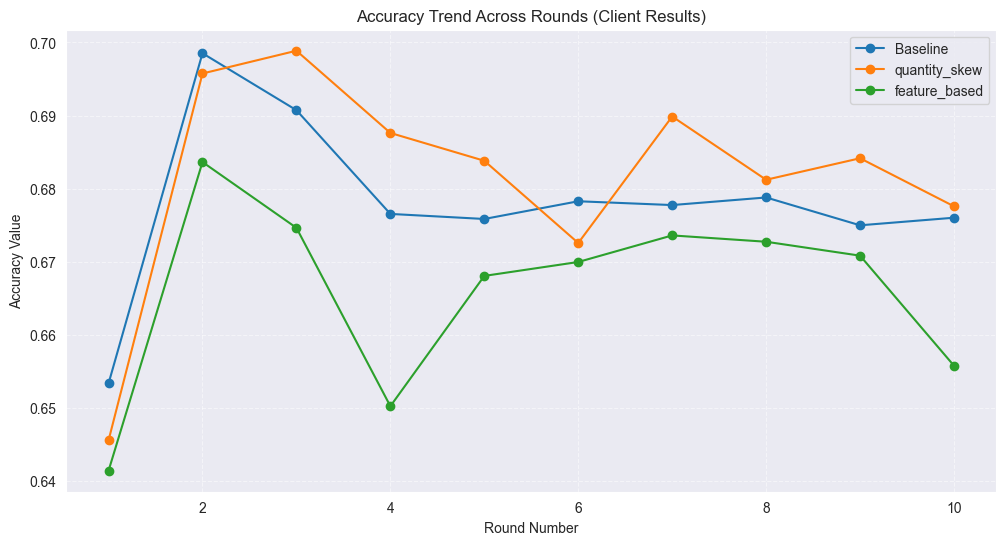

In [36]:
plot_metric_trend(experiments, "accuracy", client_or_server="client", output_dir=output_dir)

In [11]:
def plot_metric_trend_with_std_dev(experiments, metric_name, client_or_server="server", output_dir="output"):
    """
    Plots a line chart of the specified metric (accuracy, precision, recall, F1) across rounds for each experiment.
    Adds a shaded standard deviation for client results, regardless of the selected results type (server or client).
    Displays the plot and saves it in the specified output directory, starting from round 1.

    Args:
        experiments (list): List of loaded experiment data.
        metric_name (str): The metric to plot (e.g., "accuracy", "precision", "recall", "f1_score").
        client_or_server (str): Whether to use "server" or "client" results. Defaults to "server".
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10.colors  # Use a colormap for consistent colors

    for i, experiment in enumerate(experiments):
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])
        rounds = []
        mean_values = []
        std_dev_values = []

        # Extract server or client results
        if client_or_server == "server":
            for result in experiment["server_results"]:
                round_number = result["round"]
                if round_number < 1:  # Skip rounds less than 1
                    continue
                rounds.append(round_number)
                # Use server metric for the line plot
                mean_values.append(result["server_metrics"].get(metric_name, None))
                # Use client-level standard deviation for shading
                client_results = experiment["client_results"].get(str(round_number), {})
                client_metrics = [
                    client_data.get(metric_name, None)
                    for client_data in client_results.values()
                    if metric_name in client_data
                ]
                std_dev_values.append(np.std(client_metrics) if client_metrics else 0)

        elif client_or_server == "client":
            for round_number, client_results in experiment["client_results"].items():
                round_number = int(round_number)
                if round_number < 1:  # Skip rounds less than 1
                    continue
                client_metrics = [
                    client_data.get(metric_name, None)
                    for client_data in client_results.values()
                    if metric_name in client_data
                ]
                if client_metrics:
                    rounds.append(round_number)
                    mean_values.append(np.mean(client_metrics))
                    std_dev_values.append(np.std(client_metrics))

        # Ensure rounds and metrics are sorted
        sorted_indices = np.argsort(rounds)
        rounds = np.array(rounds)[sorted_indices]
        mean_values = np.array(mean_values)[sorted_indices]
        std_dev_values = np.array(std_dev_values)[sorted_indices]

        # Plot the line for mean values
        plt.plot(
            rounds,
            mean_values,
            label=experiment_name,
            color=colors[i % len(colors)],
            marker="o",
        )

        # Add the shaded area for standard deviation
        plt.fill_between(
            rounds,
            mean_values - std_dev_values,
            mean_values + std_dev_values,
            color=colors[i % len(colors)],
            alpha=0.2,
        )

    # Configure plot labels and legend
    plt.title(f"{metric_name.capitalize()} Trend Across Rounds with Standard Deviation")
    plt.xlabel("Round Number")
    plt.ylabel(f"{metric_name.capitalize()} Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{metric_name}_{client_or_server}_trend_with_std_dev.png")
    plt.savefig(output_path)

    # Show the plot
    plt.show()

    print(f"Plot saved to {output_path}")


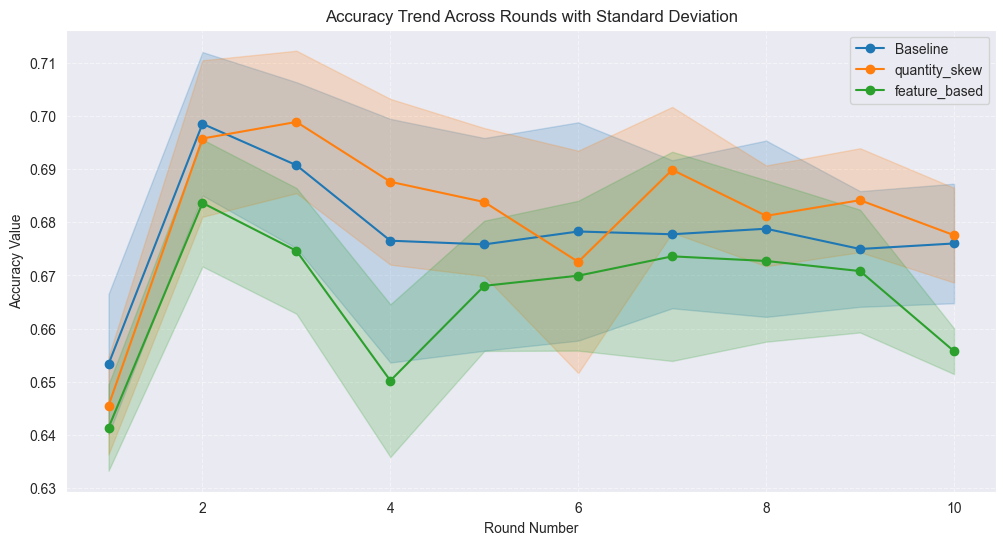

Plot saved to results/split\accuracy_client_trend_with_std_dev.png


In [12]:
plot_metric_trend_with_std_dev(experiments, "accuracy", client_or_server="client", output_dir=output_dir)

In [13]:
def plot_grouped_bar_chart(experiments, round_number, output_dir="output"):
    """
    Plots a grouped bar chart showing accuracy, precision, recall, and F1 score for each experiment in a specific round.
    Displays the plot and saves it in the specified output directory. Annotates bar values.

    Args:
        experiments (list): List of loaded experiment data.
        round_number (int): The round number to extract data for.
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    # Metrics to include in the grouped bar chart
    metrics = ["accuracy", "precision", "recall", "f1_score"]
    metric_labels = [metric.capitalize() for metric in metrics]

    # Prepare data
    experiment_names = []
    grouped_data = {metric: [] for metric in metrics}

    for experiment in experiments:
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])
        experiment_names.append(experiment_name)

        # Extract server metrics for the specified round
        round_data = next((r for r in experiment["server_results"] if r["round"] == round_number), None)
        if round_data:
            for metric in metrics:
                grouped_data[metric].append(round_data["server_metrics"].get(metric, 0))
        else:
            # Append 0 if round data is missing
            for metric in metrics:
                grouped_data[metric].append(0)

    # Bar chart configuration
    x = np.arange(len(experiment_names))  # Experiment indices for x-axis
    bar_width = 0.2  # Width of each bar
    colors = plt.cm.tab10.colors  # Use consistent colormap

    plt.figure(figsize=(12, 6))

    # Plot each metric as a bar group
    for i, metric in enumerate(metrics):
        bars = plt.bar(
            x + i * bar_width,  # Adjust bar position for grouping
            grouped_data[metric],
            bar_width,
            label=metric_labels[i],
            color=colors[i % len(colors)],
        )
        # Add annotations on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,  # Adjust position slightly above the bar
                f"{height:.2f}",  # Format value to 2 decimal places
                ha="center",
                va="bottom",
                fontsize=9,
            )

    # Configure x-axis labels and ticks
    plt.xticks(x + (len(metrics) - 1) * bar_width / 2, experiment_names, rotation=45)
    plt.xlabel("Experiments")
    plt.ylabel("Metric Value")
    plt.title(f"Grouped Metrics for Round {round_number}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"grouped_metrics_round_{round_number}.png")
    plt.savefig(output_path)

    # Show the plot
    plt.show()

    print(f"Grouped bar chart saved to {output_path}")


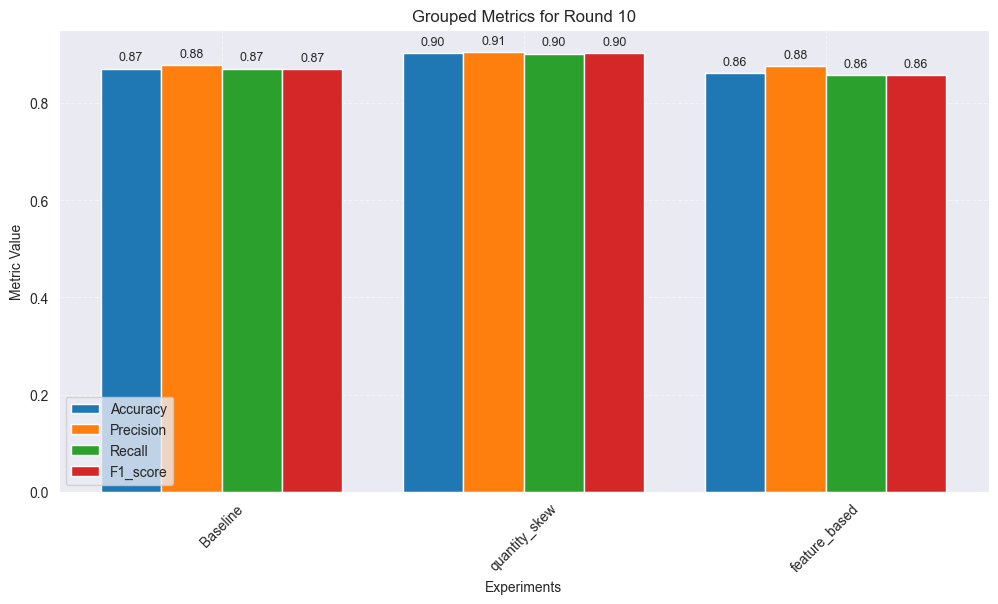

Grouped bar chart saved to results/split\grouped_metrics_round_10.png


In [14]:
plot_grouped_bar_chart(experiments, round_number=10, output_dir=output_dir)

In [15]:
def plot_grouped_bar_chart_for_clients(experiments, experiment_name, round_number, output_dir="output"):
    """
    Plots a grouped bar chart showing accuracy, precision, recall, and F1 score for each client in a specific round
    for a given experiment. Displays the plot and saves it in the specified output directory. Annotates bar values.

    Args:
        experiments (list): List of loaded experiment data.
        experiment_name (str): The name of the experiment to visualize.
        round_number (int): The round number to extract data for.
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    # Metrics to include in the grouped bar chart
    metrics = ["accuracy", "precision", "recall", "f1_score"]
    metric_labels = [metric.capitalize() for metric in metrics]

    # Find the specified experiment
    experiment = next((exp for exp in experiments if exp.get("custom_name") == experiment_name), None)
    if not experiment:
        print(f"Experiment '{experiment_name}' not found.")
        return

    # Prepare data
    client_ids = []
    grouped_data = {metric: [] for metric in metrics}

    # Extract client results for the specified round
    round_data = experiment.get("client_results", {}).get(str(round_number), {})
    for client_id, client_data in round_data.items():
        client_ids.append(client_id)
        for metric in metrics:
            grouped_data[metric].append(client_data.get(metric, 0))

    # Bar chart configuration
    x = np.arange(len(client_ids))  # Client indices for x-axis
    bar_width = 0.2  # Width of each bar
    colors = plt.cm.tab10.colors  # Use consistent colormap

    plt.figure(figsize=(12, 6))

    # Plot each metric as a bar group
    for i, metric in enumerate(metrics):
        bars = plt.bar(
            x + i * bar_width,  # Adjust bar position for grouping
            grouped_data[metric],
            bar_width,
            label=metric_labels[i],
            color=colors[i % len(colors)],
        )
        # Add annotations on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,  # Adjust position slightly above the bar
                f"{height:.2f}",  # Format value to 2 decimal places
                ha="center",
                va="bottom",
                fontsize=9,
            )

    # Configure x-axis labels and ticks
    plt.xticks(x + (len(metrics) - 1) * bar_width / 2, client_ids, rotation=45)
    plt.xlabel("Clients")
    plt.ylabel("Metric Value")
    plt.title(f"Grouped Metrics for Round {round_number} (Experiment: {experiment_name})")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{experiment_name}_clients_round_{round_number}.png")
    plt.savefig(output_path)

    # Show the plot
    plt.show()

    print(f"Grouped bar chart saved to {output_path}")


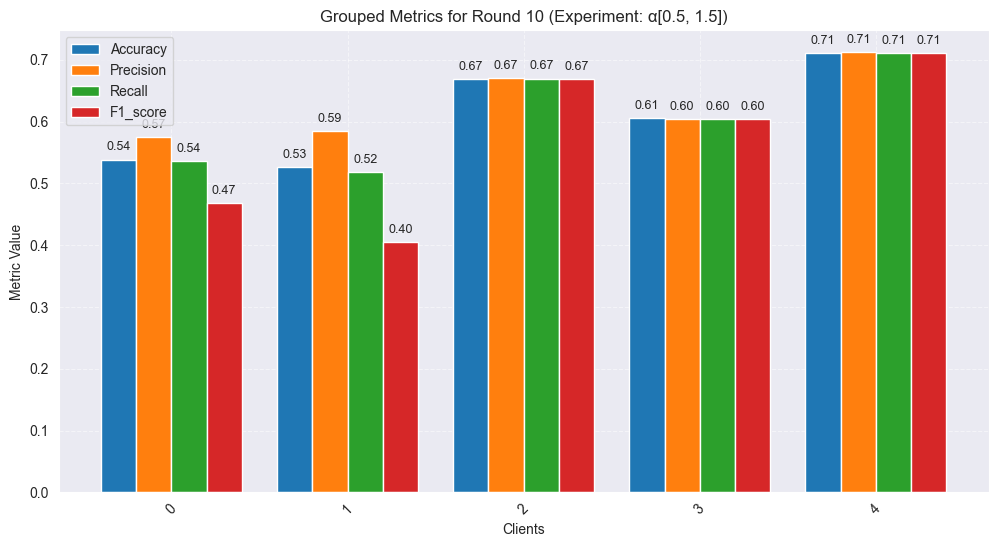

Grouped bar chart saved to results/contrast\α[0.5, 1.5]_clients_round_10.png


In [22]:
plot_grouped_bar_chart_for_clients(experiments, experiment_name="α[0.5, 1.5]", round_number=10, output_dir=output_dir)

In [16]:
def plot_server_metrics_distributions(experiments, output_dir="output"):
    """
    Plots a box plot showing the distribution of server metrics (accuracy, precision, recall, F1 score)
    across all experiments. Displays the plot and saves it in the specified output directory.

    Args:
        experiments (list): List of loaded experiment data.
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    # Metrics to include in the box plot
    metrics = ["accuracy", "precision", "recall", "f1_score"]

    # Prepare data
    data = []
    for experiment in experiments:
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])

        # Collect metrics for all rounds in the experiment
        for result in experiment["server_results"]:
            round_metrics = result["server_metrics"]
            for metric in metrics:
                data.append({
                    "Experiment": experiment_name,
                    "Metric": metric.capitalize(),
                    "Value": round_metrics.get(metric, 0),
                })

    # Convert to DataFrame for plotting
    import pandas as pd
    df = pd.DataFrame(data)

    # Plot the box plot
    plt.figure(figsize=(12, 6))
    import seaborn as sns
    sns.boxplot(
        data=df,
        x="Metric",
        y="Value",
        hue="Experiment",
        palette="Set2",
        width=0.6,
        fliersize=5
    )

    # Configure plot
    plt.title("Server Metrics Distributions Across Experiments")
    plt.xlabel("Metric")
    plt.ylabel("Metric Value")
    plt.legend(title="Experiments", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "server_metrics_distributions.png")
    plt.savefig(output_path, bbox_inches="tight")

    # Show the plot
    plt.show()

    print(f"Server metrics distributions saved to {output_path}")


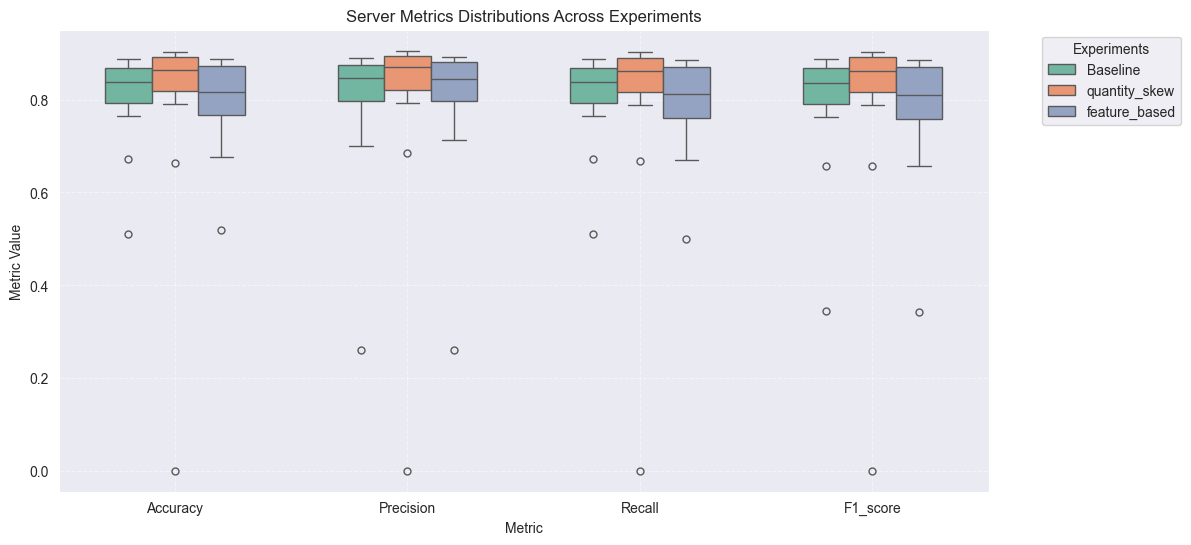

Server metrics distributions saved to results/split\server_metrics_distributions.png


In [17]:
plot_server_metrics_distributions(experiments, output_dir= output_dir)

In [18]:
def plot_metric_std_dev_across_experiments(experiments, metric_name, round_number=10, output_dir="output"):
    """
    Plots a bar chart showing the standard deviation of a given metric across experiments for a specific round.

    Args:
        experiments (list): List of loaded experiment data.
        metric_name (str): The metric to compute standard deviation for (e.g., "accuracy").
        round_number (int): The round number to extract data for. Defaults to 10.
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    # Prepare data
    experiment_names = []
    std_dev_values = []

    for experiment in experiments:
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])
        experiment_names.append(experiment_name)

        # Extract client results for the specified round
        round_data = experiment.get("client_results", {}).get(str(round_number), {})
        client_metrics = [
            client_data.get(metric_name, None)
            for client_data in round_data.values()
            if metric_name in client_data
        ]

        # Calculate standard deviation for the round
        if client_metrics:
            std_dev_values.append(np.std(client_metrics))
        else:
            std_dev_values.append(0)  # Append 0 if no data is available

    # Plotting the standard deviation values
    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        experiment_names,
        std_dev_values,
        color="skyblue",
        edgecolor="black",
        alpha=0.8
    )

    # Annotate bars with values
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,  # Adjust position slightly above the bar
            f"{height:.2f}",  # Format value to 2 decimal places
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # Configure plot
    plt.title(f"Standard Deviation of {metric_name.capitalize()} Across Experiments (Round {round_number})")
    plt.xlabel("Experiments")
    plt.ylabel(f"Standard Deviation of {metric_name.capitalize()}")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"std_dev_{metric_name}_round_{round_number}.png")
    plt.savefig(output_path, bbox_inches="tight")

    # Show the plot
    plt.show()

    print(f"Standard deviation plot saved to {output_path}")


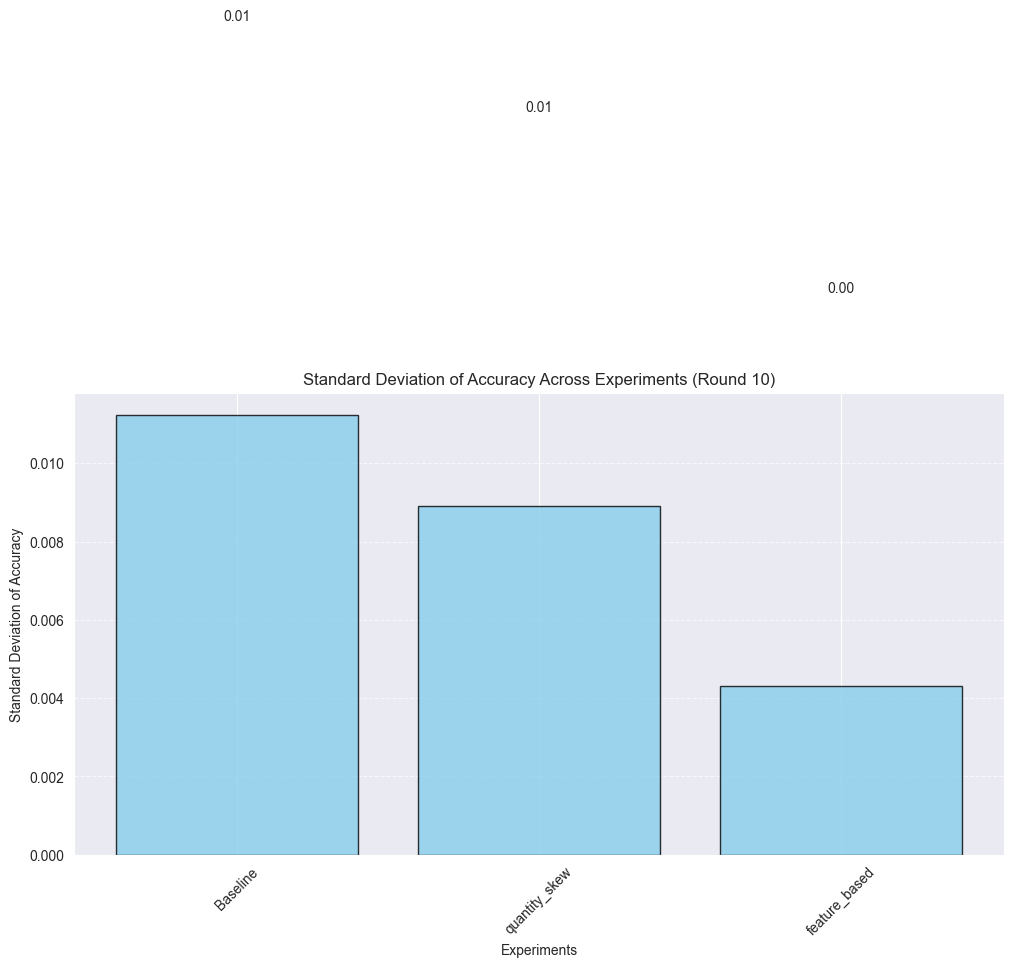

Standard deviation plot saved to results/split\std_dev_accuracy_round_10.png


In [19]:
plot_metric_std_dev_across_experiments(experiments, "accuracy", round_number=10, output_dir=output_dir)


In [20]:
def plot_metric_boxplot_across_experiments(experiments, metric_name, output_dir="output"):
    """
    Plots a box plot showing the mean of a given metric across all rounds and the standard deviation
    for each experiment. Displays the plot and saves it in the specified output directory.

    Args:
        experiments (list): List of loaded experiment data.
        metric_name (str): The metric to analyze (e.g., "accuracy").
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    # Prepare data
    data = []
    for experiment in experiments:
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])
        round_means = []

        # Extract client results for all rounds
        for round_number, client_results in experiment.get("client_results", {}).items():
            client_metrics = [
                client_data.get(metric_name, None)
                for client_data in client_results.values()
                if metric_name in client_data
            ]
            if client_metrics:
                round_means.append(np.mean(client_metrics))  # Calculate mean for this round

        # Append data for the experiment
        if round_means:
            data.append({
                "Experiment": experiment_name,
                "Mean Metric": np.mean(round_means),
                "Std Dev": np.std(round_means)
            })

    # Convert to DataFrame for plotting
    import pandas as pd
    df = pd.DataFrame(data)

    # Plot the box plot
    plt.figure(figsize=(12, 6))
    import seaborn as sns
    sns.boxplot(
        data=df,
        x="Experiment",
        y="Mean Metric",
        width=0.6,
        palette="Set2",
        fliersize=5
    )

    # Overlay standard deviations as scatter points
    plt.scatter(df["Experiment"], df["Std Dev"], color="red", label="Standard Deviation", zorder=5)

    # Configure plot
    plt.title(f"Mean and Std Dev of {metric_name.capitalize()} Across Experiments")
    plt.xlabel("Experiments")
    plt.ylabel(f"Mean {metric_name.capitalize()} Value")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"boxplot_{metric_name}_across_experiments.png")
    plt.savefig(output_path, bbox_inches="tight")

    # Show the plot
    plt.show()

    print(f"Box plot saved to {output_path}")


C:\Users\Shuvanon\AppData\Local\Temp\ipykernel_13440\3408954698.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


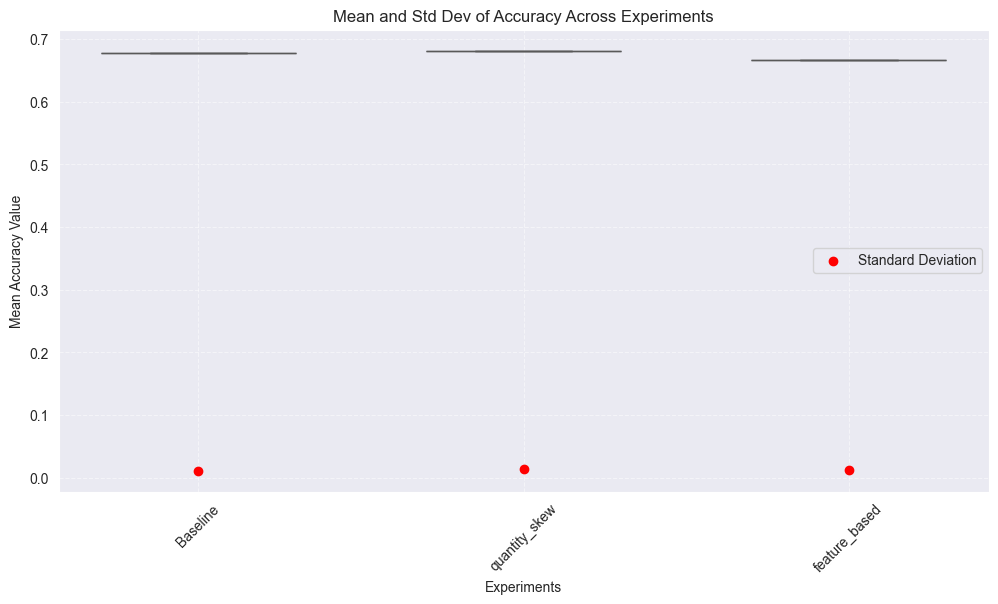

Box plot saved to results/split\boxplot_accuracy_across_experiments.png


In [21]:
plot_metric_boxplot_across_experiments(experiments, "accuracy", output_dir=output_dir)

In [22]:
from math import pi
import matplotlib.pyplot as plt

def plot_radar_chart_for_experiments(experiments, output_dir="output"):
    """
    Plots a radar chart comparing accuracy, precision, recall, and F1 score across experiments.
    Displays the plot and saves it in the specified output directory.

    Args:
        experiments (list): List of loaded experiment data.
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    # Metrics to include in the radar chart
    metrics = ["accuracy", "precision", "recall", "f1_score"]
    metric_labels = [metric.capitalize() for metric in metrics]

    # Prepare data
    experiment_names = []
    mean_metrics = []

    for experiment in experiments:
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])
        experiment_names.append(experiment_name)

        # Calculate mean of each metric across all rounds
        metric_means = []
        for metric in metrics:
            metric_values = []
            for round_number, client_results in experiment.get("client_results", {}).items():
                client_metrics = [
                    client_data.get(metric, None)
                    for client_data in client_results.values()
                    if metric in client_data
                ]
                if client_metrics:
                    metric_values.append(np.mean(client_metrics))
            metric_means.append(np.mean(metric_values) if metric_values else 0)
        mean_metrics.append(metric_means)

    # Radar chart setup
    num_metrics = len(metrics)
    angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
    angles += angles[:1]  # Close the circle

    # Create the radar chart
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)

    # Plot each experiment
    for i, experiment_name in enumerate(experiment_names):
        values = mean_metrics[i] + mean_metrics[i][:1]  # Close the circle
        ax.plot(angles, values, label=experiment_name, marker="o")
        ax.fill(angles, values, alpha=0.1)

    # Add labels
    plt.xticks(angles[:-1], metric_labels)
    ax.set_rlabel_position(30)
    plt.yticks(
        np.linspace(0, 1, 5),
        ["0", "0.25", "0.5", "0.75", "1"],
        color="grey",
        size=10,
    )
    plt.ylim(0, 1)

    # Title and legend
    plt.title("Experiment Comparison Using Radar Chart", size=15, pad=20)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "radar_chart_experiments.png")
    plt.savefig(output_path, bbox_inches="tight")

    # Show the plot
    plt.show()

    print(f"Radar chart saved to {output_path}")


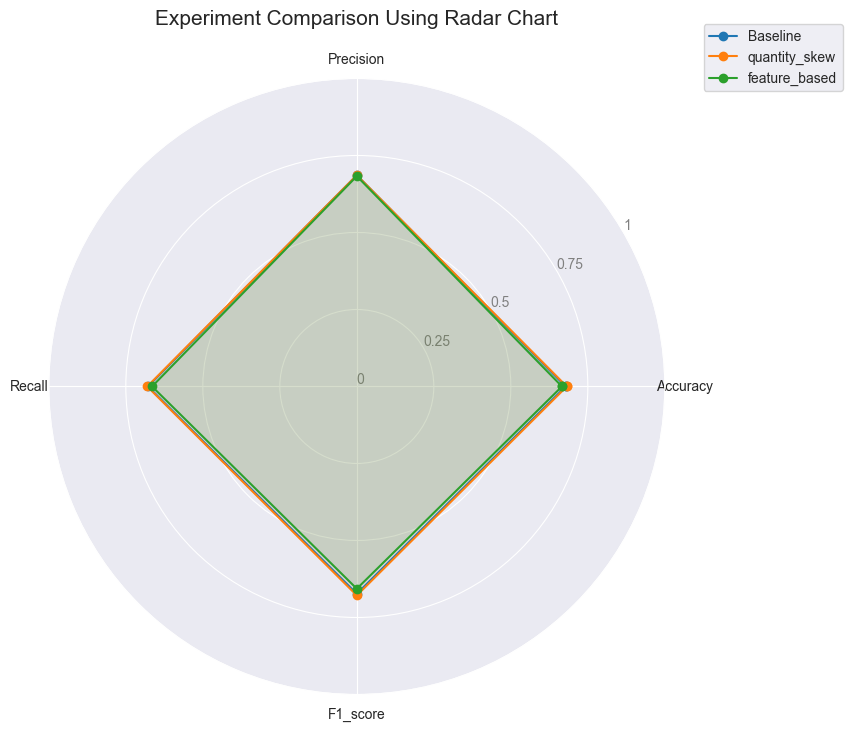

Radar chart saved to results/split\radar_chart_experiments.png


In [23]:
plot_radar_chart_for_experiments(experiments, output_dir=output_dir)

In [24]:
def plot_side_by_side_boxplot(experiments, metric_name, output_dir="output"):
    """
    Plots a side-by-side box plot for the given metric, showing its distribution across all experiments.
    Displays the plot and saves it in the specified output directory.

    Args:
        experiments (list): List of loaded experiment data.
        metric_name (str): The metric to analyze (e.g., "accuracy").
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    # Prepare data
    data = []
    for experiment in experiments:
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])

        # Collect the metric values across all rounds
        metric_values = []
        for round_number, client_results in experiment.get("client_results", {}).items():
            client_metrics = [
                client_data.get(metric_name, None)
                for client_data in client_results.values()
                if metric_name in client_data
            ]
            if client_metrics:
                metric_values.extend(client_metrics)  # Collect all client metrics for the round

        # Append data for the experiment
        if metric_values:
            data.extend([{"Experiment": experiment_name, "Value": value} for value in metric_values])

    # Convert to DataFrame for plotting
    import pandas as pd
    df = pd.DataFrame(data)

    # Plot the box plot
    plt.figure(figsize=(12, 6))
    import seaborn as sns
    sns.boxplot(data=df, x="Experiment", y="Value", palette="Set2", width=0.6, fliersize=5)

    # Configure plot
    plt.title(f"Distribution of {metric_name.capitalize()} Across Experiments")
    plt.xlabel("Experiments")
    plt.ylabel(f"{metric_name.capitalize()} Value")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"boxplot_{metric_name}_across_experiments.png")
    plt.savefig(output_path, bbox_inches="tight")

    # Show the plot
    plt.show()

    print(f"Side-by-side box plot saved to {output_path}")


C:\Users\Shuvanon\AppData\Local\Temp\ipykernel_13440\1990725312.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Experiment", y="Value", palette="Set2", width=0.6, fliersize=5)


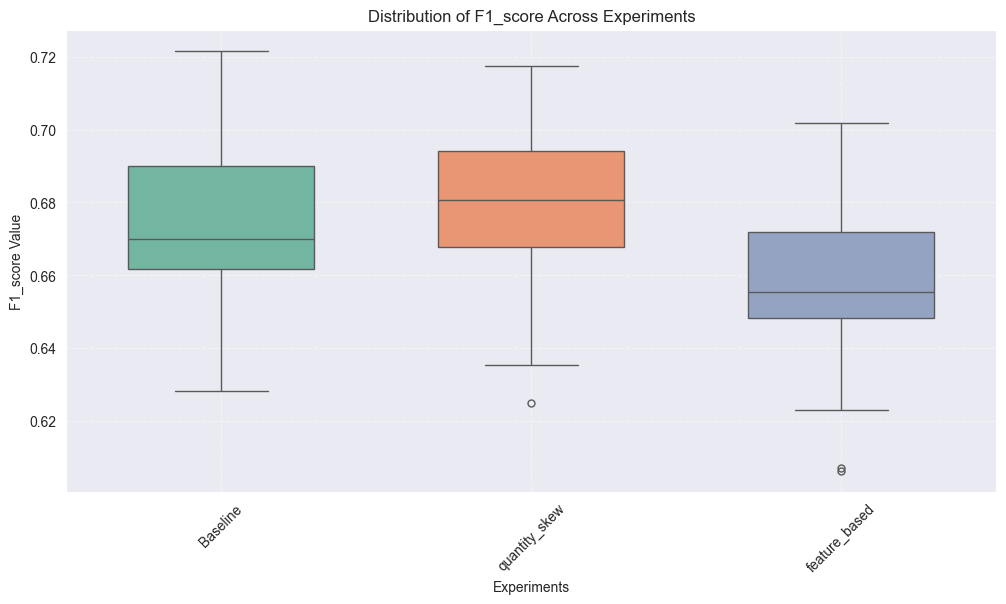

Side-by-side box plot saved to results/split\boxplot_f1_score_across_experiments.png


In [25]:
plot_side_by_side_boxplot(experiments, "f1_score", output_dir=output_dir)

In [26]:
def plot_heatmap_of_mean_metrics(experiments, round_number=None, output_dir="output"):
    """
    Plots a heatmap of the mean metrics (accuracy, precision, recall, F1 score) across experiments.
    Optionally calculates the mean for a specific round; otherwise, includes all rounds.
    Displays the plot and saves it in the specified output directory.

    Args:
        experiments (list): List of loaded experiment data.
        round_number (int or None): Round number to calculate metrics for. Defaults to None (all rounds).
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    # Metrics to include in the heatmap
    metrics = ["accuracy", "precision", "recall", "f1_score"]

    # Prepare data
    heatmap_data = []
    experiment_names = []

    for experiment in experiments:
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])
        experiment_names.append(experiment_name)

        # Calculate mean of each metric based on the provided round number
        metric_means = []
        for metric in metrics:
            metric_values = []

            # Handle data for a specific round or all rounds
            if round_number is not None:
                # Use data from the specified round only
                round_data = experiment.get("client_results", {}).get(str(round_number), {})
                client_metrics = [
                    client_data.get(metric, None)
                    for client_data in round_data.values()
                    if metric in client_data
                ]
                if client_metrics:
                    metric_values.append(np.mean(client_metrics))
            else:
                # Use data from all rounds
                for _, client_results in experiment.get("client_results", {}).items():
                    client_metrics = [
                        client_data.get(metric, None)
                        for client_data in client_results.values()
                        if metric in client_data
                    ]
                    if client_metrics:
                        metric_values.append(np.mean(client_metrics))

            # Calculate overall mean for the metric
            metric_means.append(np.mean(metric_values) if metric_values else 0)

        heatmap_data.append(metric_means)

    # Convert data to DataFrame for plotting
    import pandas as pd
    df = pd.DataFrame(heatmap_data, columns=[metric.capitalize() for metric in metrics], index=experiment_names)

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    import seaborn as sns
    sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar_kws={"label": "Mean Metric Value"})

    # Configure plot
    round_info = f"(Round {round_number})" if round_number is not None else "(All Rounds)"
    plt.title(f"Heatmap of Mean Metrics Across Experiments {round_info}")
    plt.xlabel("Metrics")
    plt.ylabel("Experiments")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"heatmap_mean_metrics_{'round_' + str(round_number) if round_number else 'all_rounds'}.png")
    plt.savefig(output_path, bbox_inches="tight")

    # Show the plot
    plt.show()

    print(f"Heatmap saved to {output_path}")


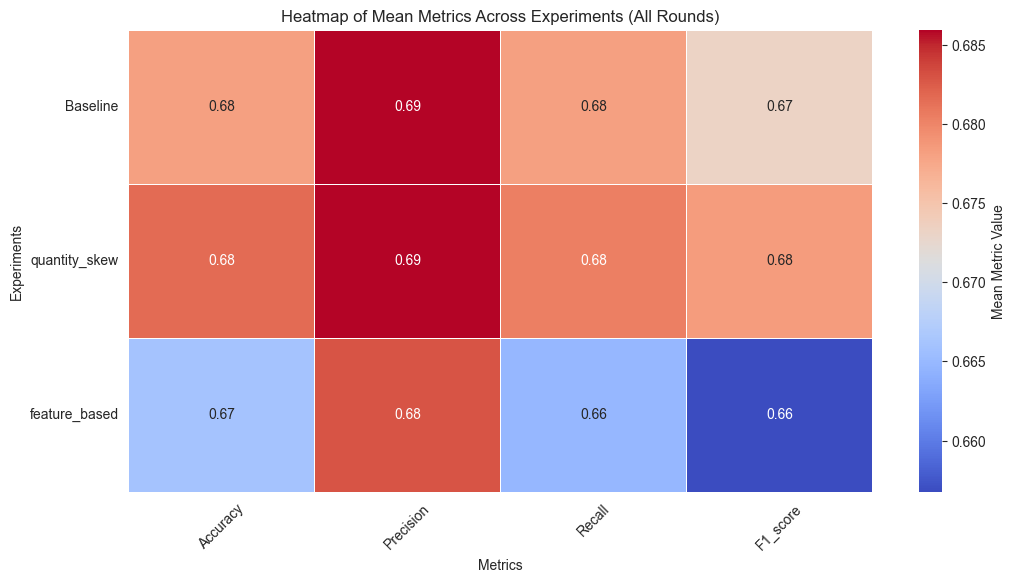

Heatmap saved to results/split\heatmap_mean_metrics_all_rounds.png


In [27]:
plot_heatmap_of_mean_metrics(experiments, round_number=None, output_dir=output_dir)

In [28]:
def plot_grouped_side_by_side_boxplot(experiments, output_dir="output"):
    """
    Plots a grouped side-by-side box plot for all metrics (accuracy, precision, recall, F1 score),
    grouping the same metrics together for comparison across experiments.
    Displays the plot and saves it in the specified output directory.

    Args:
        experiments (list): List of loaded experiment data.
        output_dir (str): Directory where the plot will be saved. Defaults to "output".
    """
    # Metrics to include
    metrics = ["accuracy", "precision", "recall", "f1_score"]
    metric_labels = [metric.capitalize() for metric in metrics]

    # Prepare data
    data = []
    for experiment in experiments:
        experiment_name = experiment.get("custom_name", experiment["config"]["experiment_name"])

        # Collect the metric values for all rounds
        for metric in metrics:
            metric_values = []
            for round_number, client_results in experiment.get("client_results", {}).items():
                client_metrics = [
                    client_data.get(metric, None)
                    for client_data in client_results.values()
                    if metric in client_data
                ]
                if client_metrics:
                    metric_values.extend(client_metrics)  # Collect all client metrics for the round

            # Append data for the experiment and metric
            if metric_values:
                data.extend([
                    {"Experiment": experiment_name, "Metric": metric.capitalize(), "Value": value}
                    for value in metric_values
                ])

    # Convert to DataFrame for plotting
    import pandas as pd
    df = pd.DataFrame(data)

    # Plot the box plot
    plt.figure(figsize=(14, 8))
    import seaborn as sns
    sns.boxplot(
        data=df,
        x="Metric",
        y="Value",
        hue="Experiment",
        palette="Set2",
        width=0.6
    )

    # Configure plot
    plt.title("Grouped Distribution of Metrics Across Experiments")
    plt.xlabel("Metrics")
    plt.ylabel("Metric Value")
    plt.legend(title="Experiments", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=0)
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the plot to the output directory
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "grouped_boxplot_metrics_across_experiments.png")
    plt.savefig(output_path, bbox_inches="tight")

    # Show the plot
    plt.show()

    print(f"Grouped side-by-side box plot saved to {output_path}")


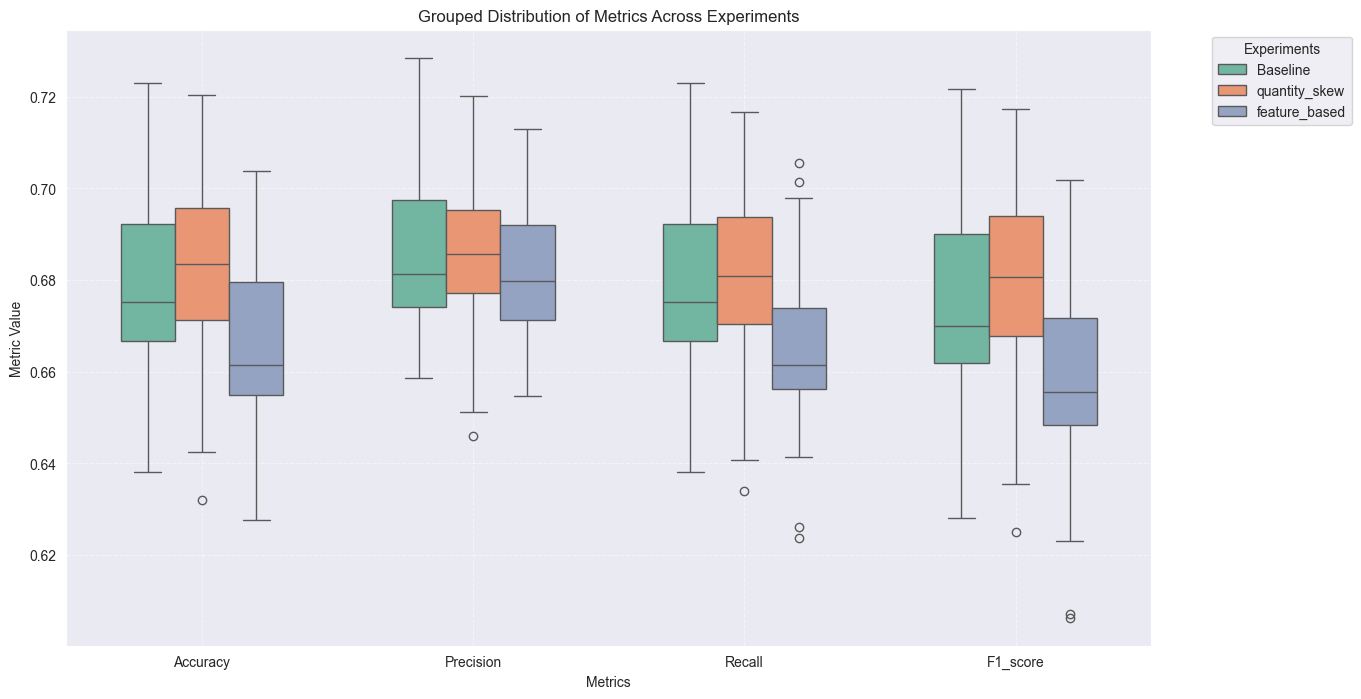

Grouped side-by-side box plot saved to results/split\grouped_boxplot_metrics_across_experiments.png


In [29]:
plot_grouped_side_by_side_boxplot(experiments, output_dir=output_dir)